# Compressible Boundary layer

## Equations

The compressible equations are given by:
$$
\begin{align}
 (Cf^{''})^{'} + ff^{''} &=0 \\
\left(\frac{C}{Pr}g_e^{'}\right)^{'} + fg_e^{'} + C\frac{u_e}{h_e}\left(f^{''}\right)^2 &=0
\end{align}
$$
With the boundary conditions:
$$f(0)=0,\quad f^{'}(0)=0,\quad g_e(0)=g_{e-w}$$
And the $Pr$ and $C$ given by:
$$
\begin{align}
Pr(g_e) &= \frac{\mu(g_e) c_p(g_e)} {k(g_e)} \\
C(g_e) &=\frac{\rho(g_e) \mu(g_e)}{\rho_e\rho_e} \\
\end{align}
$$

## Derivation ODE

Rewrite using product rule
\begin{align}
 Cf^{'''} + \left(C^{'}+ f\right)f^{''} &=0 \\
\frac{C}{Pr}g_e^{''}  + \left(\frac{C^{'}}{Pr} + C\left(\frac{1}{Pr}\right)^{'} + f \right)g_e^{'} + C\frac{u_e}{h_e}\left(f^{''}\right)^2 &=0
\end{align}
Further rewritten
$$ \frac{C}{Pr}g_e^{''}  + \left(\frac{C^{'}}{Pr} + \frac{C}{Pr^2}{Pr}^{'} + f \right)g_e^{'} + C\frac{u_e}{h_e}\left(f^{''}\right)^2 =0 $$

Define the following variables:
$$
\begin{align}
g &= f^{'}  \\
h &= g^{'}  \\
t &= g_e^{'}
\end{align}
$$

Pluggin into original equations gives:

\begin{align}
Ch^{'} + \left(C^{'}+f\right) h &= 0 \\
f' &= g \\
g' &= h \\
\frac{C}{Pr}t^{'}  + \left(\frac{C^{'}}{Pr} + \frac{C}{Pr^2}{Pr}^{'} + f \right)t + C\frac{u_e}{h_e}\left(h\right)^2 &=0 \\
g_e^{'} &= t
\end{align}

with
\begin{align}
C' &= \frac{1}{\rho_e \mu_e}\left(\rho^{'}\mu + \rho\mu^{'}\right) \\
Pr' &= \frac{1}{k}\left(\mu^{'}c_p + \mu c_p^{'} \right) - \frac{\mu c_p}{k^2} k^{'}
\end{align}



This gives the following ODEs to be solved

\begin{align}
h^{'} &=- \frac{\left(C^{'}+f\right)}{C} h  \\
f' &= g \\
g' &= h \\
t^{'}  &=- \left(\frac{C^{'}}{C} + \frac{1}{Pr}{Pr}^{'} + \frac{fPr}{C} \right)t - Pr\frac{u_e}{h_e}\left(h\right)^2 \\
g_e^{'} &= t
\end{align}



With:
$$
\begin{align}
C' &= \frac{1}{\rho_e \mu_e}\left(\rho^{'}\mu + \rho\mu^{'}\right) \\
Pr' &= \frac{1}{k}\left(\mu^{'}c_p + \mu c_p^{'} \right) - \frac{\mu c_p}{k^2} k^{'}
\end{align}
$$


## Thermodynamic properties
$$
\begin{align}
Pr(g_e) &= \frac{\mu(g_e) c_p(g_e)} {k(g_e)} \\
C(g_e) &=\frac{\rho(g_e) \mu(g_e)}{\rho_e\mu_e} \\
C' &= \frac{1}{\rho_e \mu_e}\left(\rho^{'}\mu + \rho\mu^{'}\right) \\
Pr' &= \frac{1}{k}\left(\mu^{'}c_p + \mu c_p^{'} \right) - \frac{\mu c_p}{k^2} k^{'}
\end{align}
$$

In [496]:
import CoolProp.CoolProp as CP
class tstate(object):
    def __init__(self, fluid, ge0, p0):
        self.ge0 = ge0
        self.p0 = p0        
        self.BICU = CP.AbstractState("BICUBIC&HEOS", fluid)
        self.BICU2 = CP.AbstractState("BICUBIC&HEOS", fluid)
        self.delta = 1e-10
        self.set_zeroprop()
    
    def set_zeroprop(self):
        self.BICU.update(CP.HmassP_INPUTS,self.ge0,self.p0)  
        self.mu0 = self.BICU.viscosity() 
        self.rho0= self.BICU.rhomass() 
        
    def set_prop(self,ge,t):
        self.BICU. update(CP.HmassP_INPUTS,self.ge0*ge,self.p0)  
        self.BICU2.update(CP.HmassP_INPUTS,self.ge0*ge+self.delta,self.p0)  
        #properties
        self.rho= self.BICU.rhomass()
        self.mu = self.BICU.viscosity()
        self.cp = self.BICU.cpmass()
        self.k  = self.BICU.conductivity()
        self.Pr = self.mu*self.cp/self.k
        self.C = rho(ge)*mu(ge)/(rho0*mu0)
        #derivatives
        self.dercp = (self.BICU2.cpmass()- self.cp)     /self.delta
        self.derk =  (self.BICU2.conductivity()- self.k)/self.delta
        self.dermu = (self.BICU2.viscosity()- self.mu)  /self.delta
        self.derrho =(self.BICU2.rhomass()- self.rho)   /self.delta
        self.derPr = (1/(self.rho0*self.mu0))*(self.derrho*self.mu+self.rho*self.dermu)*t
        self.derC =  (1/self.k)*(self.dermu*self.cp+self.mu*self.dercp)*t - \
                     ((self.mu*self.cp)/(self.k**2))*self.derk*t
        
        


## Solve ODES
### Numerical Method
$$
\begin{align}
h(x+\Delta x) &= h(x) -\frac{C^{'}+f(x)}{C}h(x)\Delta x& \\
f(x+\Delta x) &= f(x) +g(x)\Delta x&      \\
g(x+\Delta x) &= g(x) +h(x)\Delta x&      \\
t(x+\Delta x) &= t(x) -\left(\left(\frac{C^{'}}{C} + \frac{Pr^{'}}{Pr} + \frac{fPr}{C} \right)t(x) + Pr\frac{u_e}{h_e}h(x)^2\right)\Delta x& \\
g_e(x+\Delta x)&= g_e(x)+t(x)\Delta x& \\
\end{align} 
$$

In [489]:
import numpy as np
from scipy.optimize import minimize
n=100000
ge0 = 1e6
p0  = 2e6
ue = 10
he = 1
ts = tstate("CO2", ge0, p0)
#mesh
x = np.linspace(0,10,n); dx = np.diff(x)
#initialization
f = np.zeros(n); g = np.zeros(n); h = np.zeros(n)
ge = np.zeros(n); t = np.zeros(n)
#bc
f[0]=0; g[0]=0; ge[0]=0.9
#initial guess
h0=0.47197387; t0=0.22206645

def solve_ode(x):
    h[0]=x[0]
    t[0]=x[1]
    for i in range(0,n-1):
        ip=i+1
        ts.set_prop(ge[i], t[i])
        h[ip]=h[i]  -((ts.derC + f[i])/ts.C)*h[i]*dx[i]
        f[ip]=f[i] + g[i]*dx[i]
        g[ip]=g[i] + h[i]*dx[i]
        t[ip]=t[i] -((ts.derC/ts.C +ts.derPr/ts.Pr + (f[i]*ts.Pr)/ts.C)*t[i] 
                   + ts.Pr*h[i]**2)*dx[i]
        ge[ip]=ge[i]+t[i]*dx[i]
    error = abs(1-g[-1])+abs(1-ge[-1])
    return error

res = minimize(solve_ode, [h0,t0], method='Nelder-Mead', options={'xtol': 1e-6, 'disp': True})

In [490]:
solve_ode([h0,t0])

4.841907279562463e-07

## Plot solution

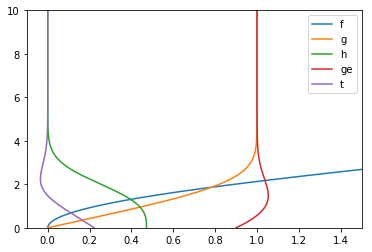

In [494]:
import matplotlib.pyplot as plt
%matplotlib inline
fig,ax = plt.subplots()
ax.plot(f, x,label='f')
ax.plot(g, x,label='g')
ax.plot(h, x,label='h')
ax.plot(ge, x,label='ge')
ax.plot(t, x,label='t')
ax.set_xbound(-.1,1.5)
ax.set_ybound(0,10)
ax.legend()
plt.savefig("blasius_vp.png")

## Store solution

In [492]:
import pandas as pd
df = pd.DataFrame(np.array([x,f,g,h,ge,t]).T,columns=['x','f','g','h','ge','t'])
df.to_csv("blasius_vp.csv",index=None, sep="\t", header=True)